<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/%5BE_16%5D/%5BE_16%5DPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트
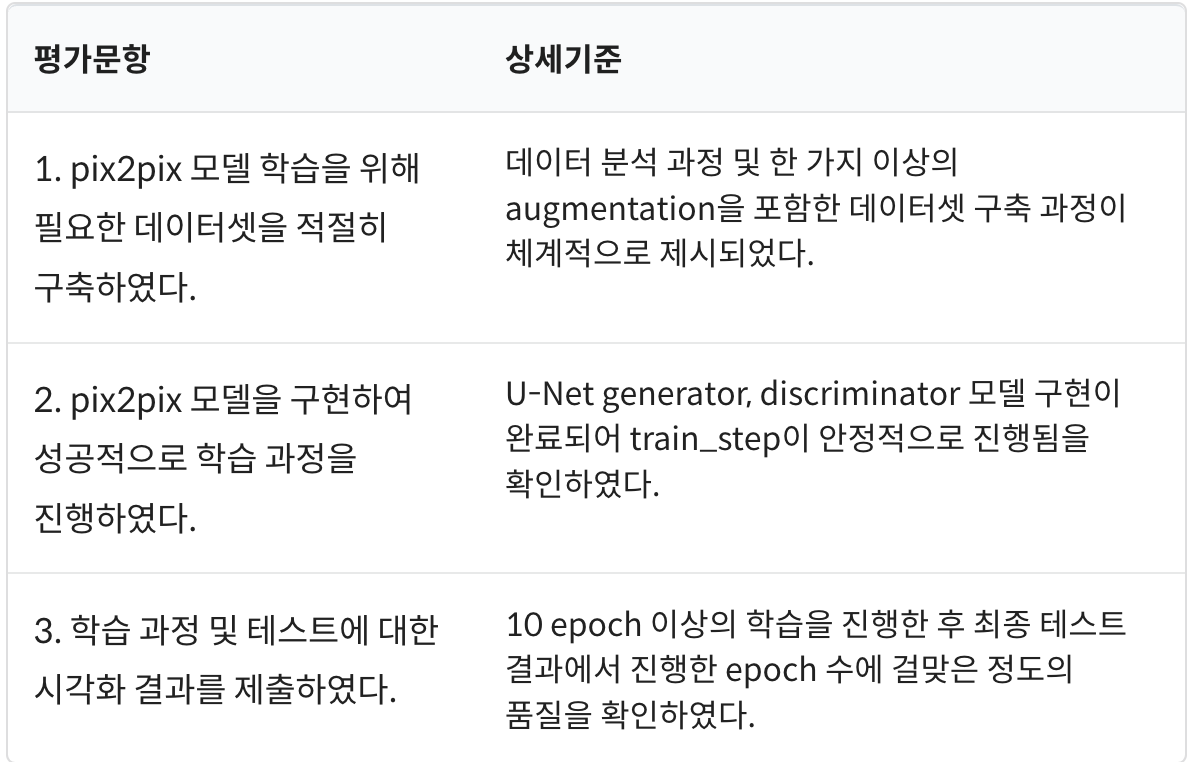

In [ ]:
#유틸리티
import time
from IPython import display 
import numpy as np
import os
import glob
import imageio
#시각화
import matplotlib.pyplot as plt
import cv2
#tensorflow
import tensorflow as tf
from tensorflow import image,data
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Input, Model,optimizers, losses
from tensorflow.keras.preprocessing.image import random_rotation

## 데이터 확인 / Augmentation

In [ ]:
train_path = '/content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/train/'
val_path = '/content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/val/'

print("number of train examples :", len(os.listdir(train_path)))
print("number of val examples :", len(os.listdir(val_path)))

number of train examples : 1000
number of val examples : 5


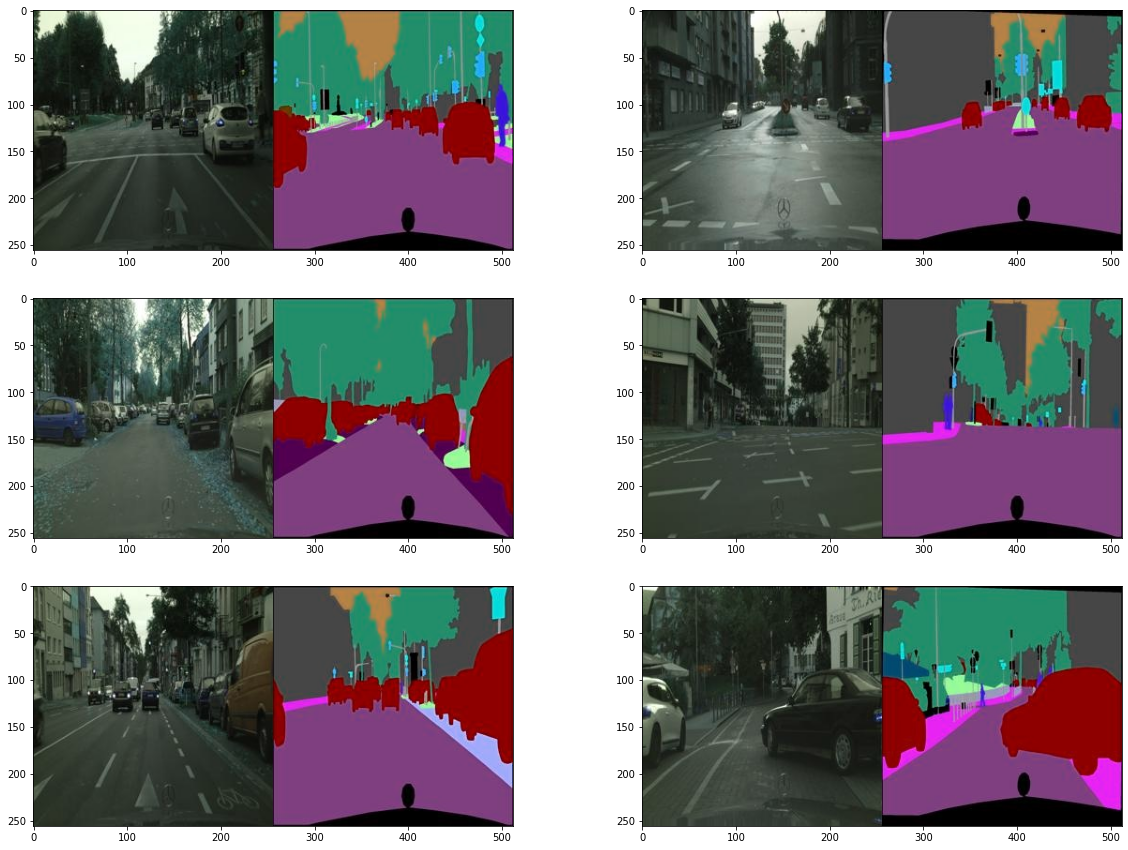

In [ ]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


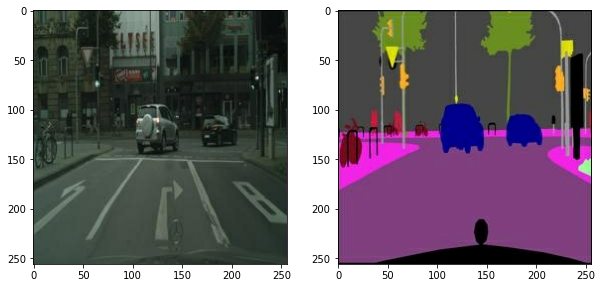

In [ ]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [ ]:
'''
두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
'''

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


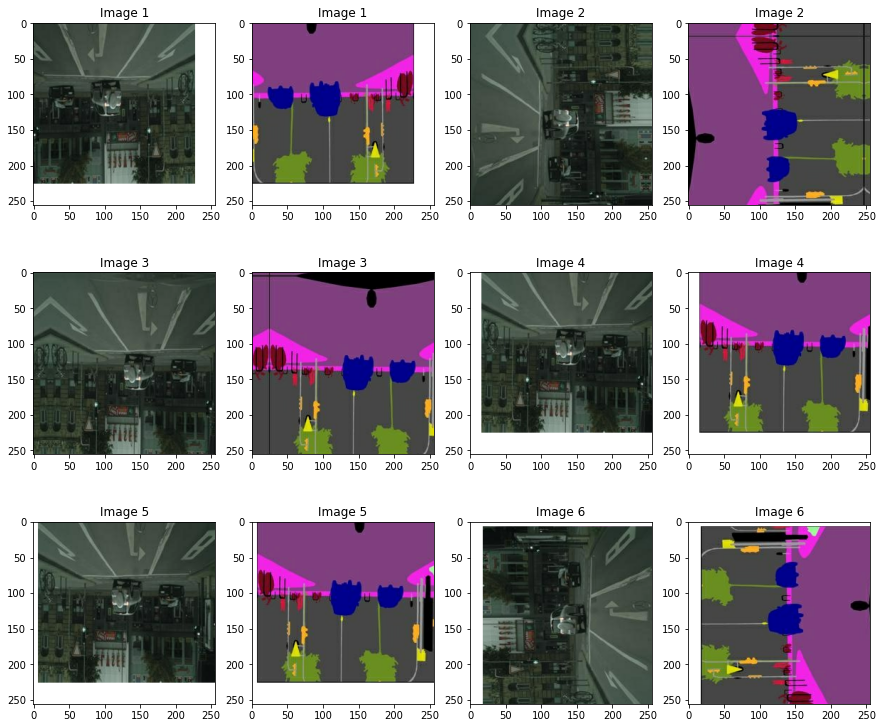

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

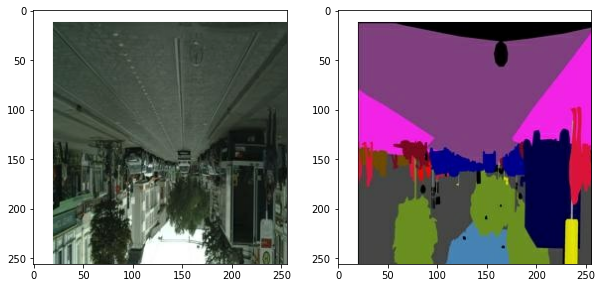

In [ ]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## UNET_Generator

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [ ]:
'''
Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고,
Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다. 
features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.
'''

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] #Encoder의 마지막 출력은 직접 Decoder로 입력됨.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): 
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [ ]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

## Discriminator

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_15 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [ ]:
'''
Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로
'''
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [ ]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

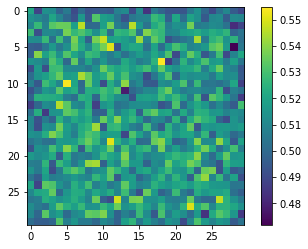

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## loss함수 / 학습

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [ ]:
@tf.function
def train_step(input_image, ground_truth, generator, discriminator):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, ground_truth, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, ground_truth, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

In [ ]:
generator = UNetGenerator()
discriminator = Discriminator()

checkpoint_dir = "/content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

val_len = len(os.listdir(val_path)) # the number ofvalidation images
print("The number of val examples: ", val_len)

The number of val examples:  5


In [ ]:
def generate_and_save_images(model, epoch, it):
    fig = plt.figure(figsize=(24, 16))

    for i in range(val_len):
        f = val_path + os.listdir(val_path)[i]
        input_image, ground_truth = load_img(f)

        pred = generator(tf.expand_dims(input_image, 0), training=False)
        pred = denormalize(pred)

        plt.subplot(1, 5, i+1)
        plt.imshow(pred[0])
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

In [ ]:
# history
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

def train(train_images, epochs, save_every, generator, discriminator):
    start = time.time()

    for epoch in range(1, EPOCHS+1):
        epoch_start = time.time()
        for i, (input_image, ground_truth) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(input_image, ground_truth, generator, discriminator)

            history['gen_loss'].append(g_loss)
            history['l1_loss'].append(l1_loss)
            history['disc_loss'].append(d_loss)

            if (i+1) % 50 == 0:
                display.clear_output(wait=False)
                generate_and_save_images(generator, epoch + 1, i + 1)
                print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                        \nGenerator_loss: {g_loss.numpy():.4f} \
                        \nL1_loss: {l1_loss.numpy():.4f} \
                        \nDiscriminator_loss: {d_loss.numpy():.4f} \
                        \nTime for epoch {epoch} : {int(time.time()-epoch_start)} sec", end="\n\n")
                train_time = time.strftime('%H:%M:%S', time.gmtime(int(time.time()-start)))
                print(f'>>>> Time for training: {train_time}', end="\n\n")

        if epoch % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix) # save checkpoint

        display.clear_output(wait=False)
        generate_and_save_images(generator, epoch, i)
        train_time = time.strftime('%H:%M:%S', time.gmtime(int(time.time()-start)))
        print(f'>>>> Time for training: {train_time}', end="\n\n")

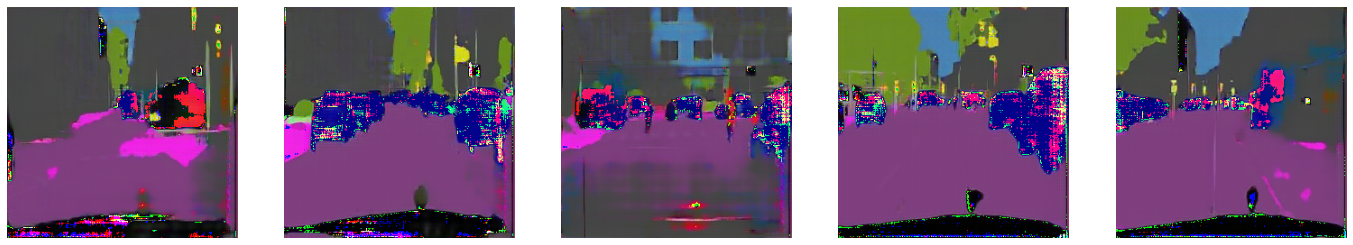

>>>> Time for training: 05:06:18



In [ ]:
EPOCHS = 500
save_every = 5

%time
with tf.device('/GPU:0'):
    train(train_images, EPOCHS, save_every, generator, discriminator)

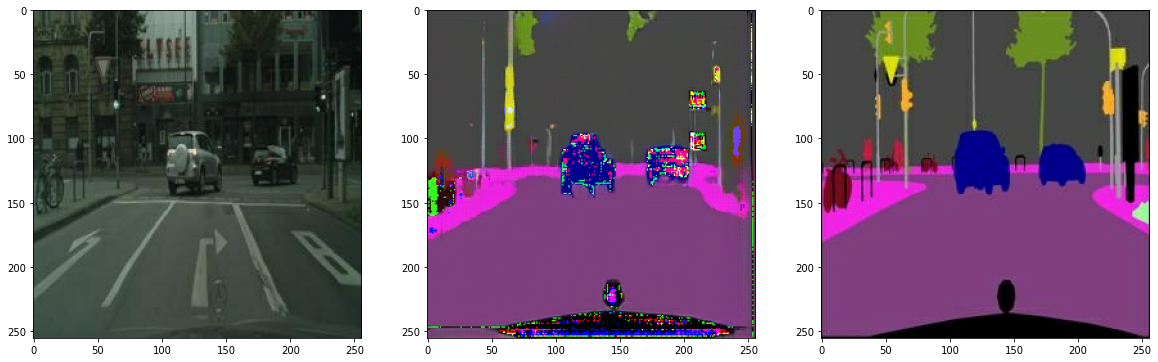

In [ ]:
test_ind = 1

f = train_path + os.listdir(train_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
anim_file = '/content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/generated_cityscapes.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/generated_samples/sample_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/generated_cityscapes.gif

-rw------- 1 root root 32789055 Jun 23 16:34 /content/drive/MyDrive/Aiffel/data/conditional_generation/data/cityscapes/generated_cityscapes.gif


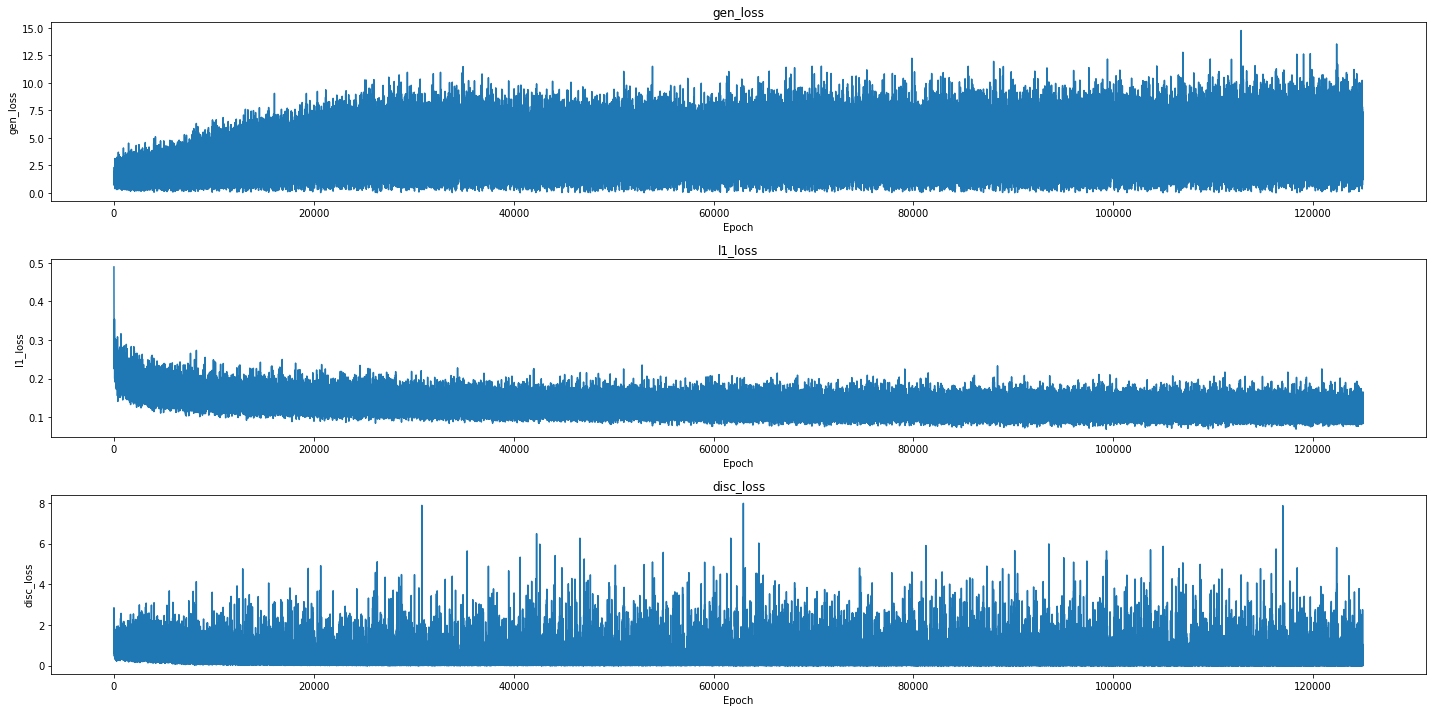

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(311)   
plt.plot(history['gen_loss'])
plt.title('gen_loss')
plt.xlabel('Epoch')
plt.ylabel('gen_loss')
plt.subplot(312)   
plt.plot(history['l1_loss'])
plt.title('l1_loss')
plt.xlabel('Epoch')
plt.ylabel('l1_loss')
plt.subplot(313)   
plt.plot(history['disc_loss'])
plt.title('disc_loss')
plt.xlabel('Epoch')
plt.ylabel('disc_loss')
plt.tight_layout()
plt.show()